## Technical level - 10 classes with upsammpling
Model: google-bert/bert-base-multilingual-uncased
dev: 20%
max_seq_length": 128
"train_batch_size": 8,
"eval_batch_size": 8,
"num_train_epochs": 1 and 5
weights: no and with


In [1]:
import pandas as pd
import torch
import os
import logging
import glob
import codecs
import numpy as np
import csv
import math
import numpy
from tqdm import tqdm, tqdm_notebook, trange
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import torch
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset, WeightedRandomSampler)
from tensorboardX import SummaryWriter
from transformers import (BertConfig, AutoTokenizer, BertTokenizer, BertForMaskedLM, AutoModelForMaskedLM, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup)
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix

## Config

In [3]:
#PATH TO DATA 
train_articles = "C:/N/st/UCU/5sem2024_DIPLOMA/Manipulation/code/my_master/datasets/upsampling/train_TC"
#dev_articles = "C:/N/st/UCU/5sem2024_DIPLOMA/Manipulation/code/my_master/datasets/upsampling/dev_TC"
train_TC_labels = "C:/N/st/UCU/5sem2024_DIPLOMA/Manipulation/code/my_master/datasets/upsampling/train_TC_labels_10_upsampling"
#dev_TC_template = "C:/N/st/UCU/5sem2024_DIPLOMA/Manipulation/code/my_master/datasets/upsampling/TC_labels_for_eval_10_upsampling.txt"  
#true_file = "C:/N/st/UCU/5sem2024_DIPLOMA/Manipulation/code/my_master/datasets/upsampling/TC.labels_true_10_upsampling.txt"

# Dev on no upsampling
dev_articles = 'C:/N/st/UCU/5sem2024_DIPLOMA/Manipulation/code/my_master/datasets/dev_new'
dev_TC_template = "C:/N/st/UCU/5sem2024_DIPLOMA/Manipulation/code/my_master/datasets/TC_labels_for_eval.txt"  
true_file = "C:/N/st/UCU/5sem2024_DIPLOMA/Manipulation/code/my_master/datasets/TC.labels_true.txt"

In [4]:
techniques = "C:/N/st/UCU/5sem2024_DIPLOMA/Manipulation/code/my_master/propaganda-techniques-names.txt"
PROP_TECH_TO_LABEL = {}  #to dictionary
LABEL_TO_PROP_TECH = {}     #to list
label = 0
with open(techniques, "r") as f:
  for technique in f:
    PROP_TECH_TO_LABEL[technique.replace("\n", "")] = int(label)
    LABEL_TO_PROP_TECH[int(label)] = technique.replace("\n", "")
    label += 1

In [5]:
device = torch.device("cuda")
n_gpu = torch.cuda.device_count()
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("LOG")

In [6]:
MODEL_CLASSES = {"bert": (BertConfig, BertForSequenceClassification, BertTokenizer)}  #BertForMaskedLM
args = {"data_dir": "C:/N/st/UCU/5sem2024_DIPLOMA/Manipulation/code/my_master/datasets/upsampling/",  
        "model_type": "bert", 
        "model_name": "google-bert/bert-base-multilingual-uncased",
        #"output_dir": "C:/N/st/UCU/5sem2024_DIPLOMA/Manipulation/code/my_master/datasets/upsampling/output_model_TC_10_with_weight_upsampling",  
        "output_dir": "C:/N/st/UCU/5sem2024_DIPLOMA/Manipulation/code/my_master/datasets/upsampling/output_model_TC_10_with_weight_upsampling_dev_no_upsamping",
        "max_seq_length": 128,  ###!
        "train_batch_size": 8,
        "eval_batch_size": 8,
        "num_train_epochs": 5, ####!1
        "weight_decay": 0,
        "learning_rate": 4e-5,
        "adam_epsilon": 1e-8,
        "warmup_ratio": 0.06,
        "warmup_steps": 0,
        "max_grad_norm": 1.0,
        "gradient_accumulation_steps": 1,
        "logging_steps": 50,
        "save_steps": 2000,
        "overwrite_output_dir": False}

## Preprocess

In [79]:
# def article_to_sequences(article_id, article, tokenizer):
#   """
#   Divides article into sequences, dividing first by sentences then to powersets
#   of the sentences
#   """
#   # Split the lines by sentences
#   curr = 0
#   lines = article.split("\n")
#   sequences = []
#   seq_starts = []
#   seq_ends = []
# 
#   # For each lines, do:
#   for line in lines:
#     # If an empty line, just continue
#     if line == "":
#       curr += 1
#       continue
# 
#     # Tokenize the line
#     tokenized = tokenizer.tokenize(line)
# 
#     # For each token, do:
#     seq_start = 0
#     for ind, token in enumerate(tokenized):
#       # Get the token without ## sign
#       mod_start_token = token.replace("##", "")
# 
#       # Find the start of the sequence in line
#       seq_start = line.lower().find(mod_start_token, seq_start)
# 
#       # Update the end of the sequence
#       seq_end = seq_start
# 
#       # For each following tokens in the line, do
#       for iter in range(1, len(tokenized) + 1 - ind):
#         # Also modify this token
#         mod_end_token = tokenized[ind + iter - 1].replace("##", "")
#         # Find the end of the token
#         seq_end = line.lower().find(mod_end_token, seq_end) + len(mod_end_token)
# 
#         sequences.append(tokenizer.convert_tokens_to_string(tokenized[ind: ind + iter]))
#         seq_starts.append(curr + seq_start)
#         seq_ends.append(curr + seq_end)
# 
#       # Update the start of the sequence
#       seq_start += len(mod_start_token)
# 
#     # Update the current whereabouts
#     curr += len(line) + 1
# 
#   dataframe = pd.DataFrame(None, range(len(sequences)), ["id", "seq_starts", "seq_ends", "label", "text"])
#   dataframe["id"] = [article_id] * len(sequences)
#   dataframe["seq_starts"] = seq_starts
#   dataframe["seq_ends"] = seq_ends
#   dataframe["label"] = [0] * len(sequences)
#   dataframe["text"] = sequences
#   return dataframe

In [80]:
# def article_labels_to_sequences(article, indices_list):
#   """
#   Divides article into sequences, where each are tagged to be propaganda or not
#   """
#   # Start at 0 indices, and split the article into lines
#   curr = 0
#   lines = article.split("\n")
#   sequences = {}
# 
#   # For each lines, do:
#   for line in lines:
#     # If an empty line, just continue after adding \n character
#     if line == "":
#       curr += 1
#       continue
# 
#     # If nothing in indices_list or current line is not part of propaganda, 
#     # just mark it to be none 
#     elif indices_list == [] or curr + len(line) <= indices_list[0][0]:
#       sequences[line] = 0
# 
#     # If current line is part of propaganda, do:
#     else:
#       # If the propaganda is contained within the line, add it accordingly
#       # and pop that indices range
#       # If the propaganda span fits entirely within the current line, the line is divided into three parts: before the propaganda, the propaganda span itself, and after the propaganda. Each part is marked with the corresponding label (0 for non-propaganda and 1 for propaganda) in the sequences dictionary.
#       if curr + len(line) >= indices_list[0][1]:
#         sequences[line[:indices_list[0][0] - curr]] = 0
#         sequences[line[indices_list[0][0] - curr:indices_list[0][1] - curr]] = 1
#         sequences[line[indices_list[0][1] - curr:]] = 0
#         indices_list.pop(0)
#       # If the propaganda goes over to the next line, add accordingly and 
#       # modify that indices range
#       #If the propaganda span extends to the next line, the line is divided into two parts: before the propaganda and after the propaganda. The start index of the next propaganda span is adjusted accordingly.
#       else:
#         sequences[line[:indices_list[0][0] - curr]] = 0
#         sequences[line[indices_list[0][0] - curr:]] = 1
#         #indices_list[0][0] = curr + len(line) + 2
#         indices_list[0] = (curr + len(line) + 2, indices_list[0][1])  #!!!!
#         indices_list[0] = tuple(indices_list[0])                        #!!!
# 
#     # Add the current line length plus \n character
#     curr += len(line) + 1
# 
#   dataframe = pd.DataFrame(None, range(len(sequences)), ["label", "text"])
#   dataframe["label"] = sequences.values()
#   dataframe["label"] = dataframe["label"].astype(int)
#   dataframe["text"] = sequences.keys()
#   return dataframe

In [7]:
def articles_to_dataframe(article_folder, label_folder):
  """
  Preprocesses the articles into dataframes with sequences with binary tags
  """
  # First sort the filenames and make sure we have label file for each articles
  article_filenames = sorted(glob.glob(os.path.join(article_folder, "*.txt")))
  label_filenames = sorted(glob.glob(os.path.join(label_folder, "*.labels.tsv")))
  assert len(article_filenames) == len(label_filenames)

  # Initialize sequences
  sequences = []

  # For each article, do:
  for i in range(len(article_filenames)):
    # Get the id name
    article_id = os.path.basename(article_filenames[i]).split(".")[0][7:]

    # Read in the article
    with codecs.open(article_filenames[i], "r", encoding="utf8") as f:
      article = f.read()

    # Read in the label file and store indices for TC task !!!!
    with open(label_filenames[i], "r") as f:
      reader = csv.reader(f, delimiter="\t")
      article_sequences = []
      labels_list = []
      for row in reader:
        article_sequences.append(article[int(row[2]):int(row[3])])
        labels_list.append(PROP_TECH_TO_LABEL[row[1]])

    sequence = pd.DataFrame(None, range(len(article_sequences)), ["label", "text"])
    sequence["label"] = labels_list
    sequence["text"] = article_sequences   

    # Add to the sequences
    sequences.append(sequence)

  # Concatenate all dataframes
  dataframe = pd.concat(sequences, ignore_index=True)

  return dataframe

In [8]:
def convert_dataframe_to_features(dataframe, max_seq_length, tokenizer):
  """
  Converts dataframe into features dataframe, where each feature will
  take form of [CLS] + A + [SEP]
  """
  # Create features
  features = pd.DataFrame(None, range(dataframe.shape[0]), 
                              ["input_ids", "input_mask", "segment_ids", "label_ids"])

  # For each sequence, do:
  for i in range(len(dataframe)):
    # Set first and second part of the sequences
    tokens = tokenizer.tokenize(dataframe["text"][i])

    # If length of the sequence is greater than max sequence length, truncate it
    if len(tokens) > max_seq_length - 2:
        tokens = tokens[:(max_seq_length - 2)]

    # Concatenate the tokens
    tokens = [tokenizer.cls_token] + tokens + [tokenizer.sep_token]

    # Compute the ids
    segment_ids = [0] * len(tokens)
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    padding_length = max_seq_length - len(input_ids)
    pad_token = tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0]
    input_ids = input_ids + [pad_token] * padding_length
    input_mask = input_mask + [0] * padding_length
    segment_ids = segment_ids + [0] * padding_length
    label_id = dataframe["label"][i]

    # Assert to make sure we have same length
    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    # Put the data into features dataframe
    features["input_ids"][i] = input_ids
    features["input_mask"][i] = input_mask
    features["segment_ids"][i] = segment_ids
    features["label_ids"][i] = int(label_id)    ###!!!
    

  return features

In [9]:
def generate_training_dataset_from_articles(articles_folders, labels_folders, tokenizer):
  """
  Generates dataset to go into BERT from articles and labels
  """
  # If generating dataset for evaluation, do:
  logger.info("Generating training dataset...")
    
  # For each articles and labels folder set, turn them into dataframes
  dataframe_list = []
  for i in range(len(articles_folders)):
    logger.info("Generating dataframe for folder %s", articles_folders[i])
    dataframe_list.append(articles_to_dataframe(articles_folders[i], labels_folders[i]))

  # Concatenate the dataframes to make a total dataframe
  dataframe = pd.concat(dataframe_list, ignore_index=True)

  print(dataframe)
  print(dataframe.shape)

  # Process into features dataframe
  logger.info("Creating features from dataframe")
  features = convert_dataframe_to_features(dataframe, args['max_seq_length'], tokenizer) #
     
  # Creating TensorDataset from features
  logger.info("Creating TensorDataset from features dataframe")
  all_input_ids = torch.tensor(features["input_ids"], dtype=torch.long)
  all_input_mask = torch.tensor(features["input_mask"], dtype=torch.long)
  all_segment_ids = torch.tensor(features["segment_ids"], dtype=torch.long)
  all_label_ids = torch.tensor(features["label_ids"], dtype=torch.long)

  dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
  
  return dataset

## Train 

In [13]:
# Without weights
def train_with_weights (train_dataset, model, tokenizer):
    """
    Trains the model with training dataset
    """
    # Initialize various necessary objects
    tb_writer = SummaryWriter()
    #train_sampler = RandomSampler(train_dataset)
    
    #Take classes from train datasets
    label_list = [label.item() for _, _, _, label in train_dataset]
    #print(label_list)
    # Read class weights from file
    class_weights = {}
    with open("C:/N/st/UCU/5sem2024_DIPLOMA/Manipulation/code/my_master/class_weights_10_numbers.txt", "r") as f:
        for line in f:
            class_name, weight = line.strip().split(":")
            class_weights[class_name.strip()] = float(weight.strip())
    #print(class_weights)
    #Convert classes to int
    class_weights = {int(key): value for key, value in class_weights.items()}
    #print(class_weights)
    weights = [class_weights[label] for label in label_list]
    #print(weights)

    # Use weighted sampler
    train_sampler = WeightedRandomSampler(weights, len(train_dataset), replacement=True)
    #train_sampler = RandomSampler(train_dataset)
    
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=args['train_batch_size']) 
    
    # Compute the total time
    t_total = len(train_dataloader) // args['gradient_accumulation_steps'] * args['num_train_epochs']
    
    # Set the grouped parameters for optimizer
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': args['weight_decay']},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
    
    # Compute warmup steps
    warmup_steps = math.ceil(t_total * args['warmup_ratio'])
    args['warmup_steps'] = warmup_steps if args['warmup_steps'] == 0 else args['warmup_steps']
    
    # Initialize optimizer as Adam with constant weight decay and a linear scheduler with warmup
    optimizer = AdamW(optimizer_grouped_parameters, lr=args['learning_rate'], eps=args['adam_epsilon'])
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=args['warmup_steps'], num_training_steps=t_total)

    
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_dataset))
    logger.info("  Num Epochs = %d", args['num_train_epochs'])
    logger.info("  Total train batch size  = %d", args['train_batch_size'])
    logger.info("  Gradient Accumulation steps = %d", args['gradient_accumulation_steps'])
    logger.info("  Total optimization steps = %d", t_total)

    # Initialize variables for training
    global_step = 0
    tr_loss, logging_loss = 0.0, 0.0
    model.zero_grad()
    train_iterator = trange(int(args['num_train_epochs']), desc="Epoch")
    
    # Start training!
    for _ in train_iterator:
        epoch_iterator = tqdm_notebook(train_dataloader, desc="Iteration")
        for step, batch in enumerate(epoch_iterator):
            model.train()
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      'token_type_ids': batch[2], 
                      'labels':         batch[3]}
            outputs = model(**inputs)
            loss = outputs[0]

            if args['gradient_accumulation_steps'] > 1:
                loss = loss / args['gradient_accumulation_steps']
                
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), args['max_grad_norm'])

            tr_loss += loss.item()
            if (step + 1) % args['gradient_accumulation_steps'] == 0:
                optimizer.step()
                scheduler.step() 
                model.zero_grad()
                global_step += 1

                if args['logging_steps'] > 0 and global_step % args['logging_steps'] == 0:
                    tb_writer.add_scalar('lr', scheduler.get_lr()[0], global_step)
                    tb_writer.add_scalar('loss', (tr_loss - logging_loss)/args['logging_steps'], global_step)
                    logging_loss = tr_loss

                if args['save_steps'] > 0 and global_step % args['save_steps'] == 0:
                    output_dir = os.path.join(args['output_dir'], 'checkpoint-{}'.format(global_step))
                    if not os.path.exists(output_dir):
                        os.makedirs(output_dir)
                    model_to_save = model.module if hasattr(model, 'module') else model
                    model_to_save.save_pretrained(output_dir)
                    logger.info("Saving model checkpoint to %s", output_dir)

    return global_step, tr_loss / global_step

### TC 10

In [11]:
config_class, model_class, tokenizer_class = MODEL_CLASSES[args["model_type"]]
config = config_class.from_pretrained(args["model_name"], num_labels=len(PROP_TECH_TO_LABEL))
tokenizer = tokenizer_class.from_pretrained(args["model_name"])
model = model_class(config)
model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [12]:
train_dataset = generate_training_dataset_from_articles([train_articles], [train_TC_labels], tokenizer)

INFO:LOG:Generating training dataset...
INFO:LOG:Generating dataframe for folder C:/N/st/UCU/5sem2024_DIPLOMA/Manipulation/code/my_master/datasets/upsampling/train_TC
INFO:LOG:Creating features from dataframe


      label                                               text
0         7  чоловік побив її, потім наніс ножові поранення...
1         9                                              шален
2         9                                           жестяков
3         9                                              крути
4         0                                  або їх відсутніст
...     ...                                                ...
4437      9         вітер штормить зі швидкістю швидше за поїз
4438      9                                      природа за на
4439      6                   швидкість вітру понад 130 км/год
4440      6                 йде війна за збереження нашої наці
4441      6                повальна мобілізація теж не допомож

[4442 rows x 2 columns]
(4442, 2)


INFO:LOG:Creating TensorDataset from features dataframe


In [14]:
global_step, tr_loss = train_with_weights(train_dataset, model, tokenizer)

C:\Users\Ната\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
INFO:LOG:***** Running training *****
INFO:LOG:  Num examples = 4442
INFO:LOG:  Num Epochs = 5
INFO:LOG:  Total train batch size  = 8
INFO:LOG:  Gradient Accumulation steps = 1
INFO:LOG:  Total optimization steps = 2780
Epoch:   0%|          | 0/5 [00:00<?, ?it/s]C:\Windows\Temp\ipykernel_21804\1280938434.py:66: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  epoch_iterator = tqdm_notebook(train_dataloader, desc="Iteration")


Iteration:   0%|          | 0/556 [00:00<?, ?it/s]

Epoch:  20%|██        | 1/5 [04:43<18:55, 283.78s/it]

Iteration:   0%|          | 0/556 [00:00<?, ?it/s]

Epoch:  40%|████      | 2/5 [09:48<14:49, 296.39s/it]

Iteration:   0%|          | 0/556 [00:00<?, ?it/s]

Epoch:  60%|██████    | 3/5 [15:05<10:10, 305.39s/it]

Iteration:   0%|          | 0/556 [00:00<?, ?it/s]

INFO:LOG:Saving model checkpoint to C:/N/st/UCU/5sem2024_DIPLOMA/Manipulation/code/my_master/datasets/upsampling/output_model_TC_10_with_weight_upsampling_dev_no_upsamping\checkpoint-2000
Epoch:  80%|████████  | 4/5 [20:48<05:20, 320.26s/it]

Iteration:   0%|          | 0/556 [00:00<?, ?it/s]

Epoch: 100%|██████████| 5/5 [27:33<00:00, 330.68s/it]


In [15]:
logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)
logger.info("Saving model checkpoint to %s", args['output_dir'])
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(args['output_dir'])
tokenizer.save_pretrained(args['output_dir'])
torch.save(args, os.path.join(args['output_dir'], 'training_args.bin'))

INFO:LOG: global_step = 2780, average loss = 0.41550041472458904
INFO:LOG:Saving model checkpoint to C:/N/st/UCU/5sem2024_DIPLOMA/Manipulation/code/my_master/datasets/upsampling/output_model_TC_10_with_weight_upsampling_dev_no_upsamping


## Evaluate

In [16]:
def generate_TC_eval_dataset_from_article(article_folder, indices_file, tokenizer):
  """
  Generates TC dataset to go into BERT from articles and labels
  """
  # If generating dataset for evaluation, do:
  logger.info("Generating evaluation dataset...")

  # First sort the filenames and make sure we have label file for each articles
  article_filenames = sorted(glob.glob(os.path.join(article_folder, "*.txt")))
  articles = {}

  # For each article, read them in:
  for i in range(len(article_filenames)):
    article_id = os.path.basename(article_filenames[i]).split(".")[0][7:]
    with codecs.open(article_filenames[i], "r", encoding="utf8") as f:
      articles[article_id] = f.read()

  # Read in indices file
  with open(indices_file, "r") as f:
    reader = csv.reader(f, delimiter="\t")
    ids_list = []
    seq_starts = []
    seq_ends = []
    article_sequences = []
    for row in reader:
      ids_list.append(row[0])
      seq_starts.append(row[2])
      seq_ends.append(row[3])
      article_sequences.append(articles[row[0]][int(row[2]):int(row[3])])

  dataframe = pd.DataFrame(None, range(len(ids_list)), ["id", "seq_starts", "seq_ends", "label", "text"])
  dataframe["id"] = ids_list
  dataframe["seq_starts"] = seq_starts
  dataframe["seq_ends"] = seq_ends
  dataframe["label"] = [0] * len(ids_list)
  dataframe["text"] = article_sequences

  print(dataframe)
  print(dataframe.shape)

  # Process into features dataframe
  logger.info("Creating features from dataframe")
  features = convert_dataframe_to_features(dataframe, args['max_seq_length'], tokenizer)
      
  # Creating TensorDataset from features
  logger.info("Creating TensorDataset from features dataframe")
  all_input_ids = torch.tensor(features["input_ids"], dtype=torch.long)
  all_input_mask = torch.tensor(features["input_mask"], dtype=torch.long)
  all_segment_ids = torch.tensor(features["segment_ids"], dtype=torch.long)
  all_label_ids = torch.tensor(features["label_ids"], dtype=torch.long)

  dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
  return dataset, dataframe

In [17]:
def classify_techniques(eval_dataframe, eval_dataset, model, tokenizer):
  """
  Classifies a single article dataset and returns article id with indices list
  """
  # Load the eval data and initialize sampler
  eval_sampler = SequentialSampler(eval_dataset)
  eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=args['eval_batch_size'])

  # Start Classification
  logger.info("***** Running classification for article {} *****".format(eval_dataframe["id"][0]))
  logger.info("  Num sequences = %d", len(eval_dataset))
  logger.info("  Batch size = %d", args['eval_batch_size'])
  preds = None

  # For each batch, evaluate
  for batch in tqdm_notebook(eval_dataloader, desc="Evaluating"):
    model.eval()
    batch = tuple(t.to(device) for t in batch)

    with torch.no_grad():
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'token_type_ids': batch[2],
                'labels':         batch[3]}
      outputs = model(**inputs)
      logits = outputs[1]

    # Get predictions
    if preds is None:
      preds = logits.detach().cpu().numpy()
    else:
      preds = numpy.append(preds, logits.detach().cpu().numpy(), axis=0)

  # Get the most probable prediction
  preds = numpy.argmax(preds, axis=1)

  return preds

In [18]:
# Dev with no synthetis data

article_filenames = sorted(glob.glob(os.path.join(dev_articles, "*.txt")))

#output_dir = "datasets"
output_file = 'C:/N/st/UCU/5sem2024_DIPLOMA/Manipulation/code/my_master/datasets/upsampling/TC.labels_pred_10_with_weight_upsampling_dev_no_upsampling_5epoch.txt'
f = open(output_file, 'w', newline='')
writer = csv.writer(f, delimiter='\t')
eval_dataset, eval_dataframe = generate_TC_eval_dataset_from_article(dev_articles, dev_TC_template, tokenizer)
predictions = classify_techniques(eval_dataframe, eval_dataset, model, tokenizer)
for i in range(len(predictions)):
  writer.writerow([eval_dataframe["id"][i], LABEL_TO_PROP_TECH[predictions[i]], eval_dataframe["seq_starts"][i], eval_dataframe["seq_ends"][i]])
f.close()

INFO:LOG:Generating evaluation dataset...
INFO:LOG:Creating features from dataframe


           id seq_starts seq_ends  label  \
0      209813          0        3      0   
1      209813         19       36      0   
2      209813         49       65      0   
3      209813        235      249      0   
4      210028          0        6      0   
...       ...        ...      ...    ...   
1027  1633033         68       80      0   
1028  1636639        325      376      0   
1029  1636685        879      885      0   
1030  1636685        968     1051      0   
1031  1636685       1183     1219      0   

                                                   text  
0                                                   ска  
1                                     продовжує ширитис  
2                                      крейзі-пухнастик  
3                                        головний прико  
4                                                виродк  
...                                                 ...  
1027                                       проживає в р  
1028  і

INFO:LOG:Creating TensorDataset from features dataframe
INFO:LOG:***** Running classification for article 209813 *****
INFO:LOG:  Num sequences = 1032
INFO:LOG:  Batch size = 8
C:\Windows\Temp\ipykernel_21804\3392312430.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm_notebook(eval_dataloader, desc="Evaluating"):


Evaluating:   0%|          | 0/129 [00:00<?, ?it/s]

In [19]:
# Read contents of template.labels_pred.txt
#pred_file = "C:/N/st/UCU/5sem2024_DIPLOMA/Manipulation/code/my_master/datasets/upsampling/TC.labels_pred_10_no_weight_upsampling_5epoch.txt"
#pred_file = "C:/N/st/UCU/5sem2024_DIPLOMA/Manipulation/code/my_master/datasets/upsampling/TC.labels_pred_10_with_weight_upsampling.txt"
pred_file = "C:/N/st/UCU/5sem2024_DIPLOMA/Manipulation/code/my_master/datasets/upsampling/TC.labels_pred_10_with_weight_upsampling_dev_no_upsampling_5epoch.txt"
#true_file = "C:/N/st/UCU/5sem2024_DIPLOMA/Manipulation/code/my_master/datasets/upsampling/TC.labels_true_10_upsampling.txt"

# Initialize dictionaries to store IDs and techniques
pred_dict = {}
true_dict = {}

# Read contents of TC.labels_pred.txt
with open(pred_file, "r") as pred_f:
    pred_reader = csv.reader(pred_f, delimiter="\t")
    for row in pred_reader:
        id_ = row[0]
        technique = row[1]
        if id_ not in pred_dict:
            pred_dict[id_] = [technique]
        else:
            pred_dict[id_].append(technique)

# Read contents of TC.labels_true.txt
with open(true_file, "r") as true_f:
    true_reader = csv.reader(true_f, delimiter="\t")
    for row in true_reader:
        id_ = row[0]
        technique = row[1]
        if id_ not in true_dict:
            true_dict[id_] = [technique]
        else:
            true_dict[id_].append(technique)

# 1 epoch

In [23]:
# Initialize lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the keys of the dictionaries
for key in true_dict.keys():
    # Check if the key exists in both dictionaries
    if key in pred_dict:
        # Append true and predicted labels
        true_labels.extend(true_dict[key])
        predicted_labels.extend(pred_dict[key])

# Generate classification report
report = classification_report(true_labels, predicted_labels)

# Print classification report
print(report)

                      precision    recall  f1-score   support

         Black_White       0.63      0.66      0.64       108
         Doubts_Army       0.00      0.00      0.00        99
   Doubts_government       0.28      0.33      0.30       115
        Doubts_media       0.46      0.68      0.55       106
        Doubts_other       0.62      0.64      0.63        83
     Doubts_partners       0.37      0.78      0.50        81
       Emotion_Anger       0.00      0.00      0.00       100
        Emotion_Fear       0.34      0.43      0.38       138
Emotion_Hate_Disgust       0.00      0.00      0.00        87
       Emotion_other       0.53      0.73      0.62       207

            accuracy                           0.45      1124
           macro avg       0.32      0.42      0.36      1124
        weighted avg       0.34      0.45      0.39      1124


C:\Users\Ната\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ната\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ната\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [30]:
# Compute multilabel confusion matrix
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

class_names = ["Doubts_government", 
               "Doubts_Army",
               "Doubts_media",
               "Doubts_partners",
               "Doubts_other",
               "Black_White",
               "Emotion_Fear",
               "Emotion_Anger",
               "Emotion_Hate_Disgust",
               "Emotion_other"]

mcm = multilabel_confusion_matrix(true_labels, predicted_labels, labels = class_names)

# Print confusion matrix
# print("Confusion Matrix:")
# for i, confusion_matrix in enumerate(mcm):
#     print(f"Class {class_names[i]}:")
#     print(confusion_matrix)
#     print()
# Compute multilabel confusion matrix with class names


# Initialize lists to store metrics for each class
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Compute metrics for each class
for i, confusion_matrix in enumerate(mcm):
    tn, fp, fn, tp = confusion_matrix.ravel()
    
    # Compute accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    accuracy_scores.append(accuracy)
    
    # Compute precision
    precision = tp / (tp + fp)
    precision_scores.append(precision)
    
    # Compute recall
    recall = tp / (tp + fn)
    recall_scores.append(recall)
    
    # Compute F1-score
    f1 = 2 * (precision * recall) / (precision + recall)
    f1_scores.append(f1)

# Aggregate metrics
overall_accuracy = accuracy_score(true_labels, predicted_labels)
overall_precision = precision_score(true_labels, predicted_labels, average='macro')
overall_recall = recall_score(true_labels, predicted_labels, average='macro')
overall_f1 = f1_score(true_labels, predicted_labels, average='macro')

# Print or use the computed metrics as needed
print("Overall Accuracy:", overall_accuracy)
print("Overall Precision:", overall_precision)
print("Overall Recall:", overall_recall)
print("Overall F1-score:", overall_f1)

Overall Accuracy: 0.45195729537366547
Overall Precision: 0.3218451023603121
Overall Recall: 0.4245255216472489
Overall F1-score: 0.36129100746611087


C:\Windows\Temp\ipykernel_14732\231912716.py:41: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
C:\Users\Ната\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C:\Windows\Temp\ipykernel_14732\4176344692.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


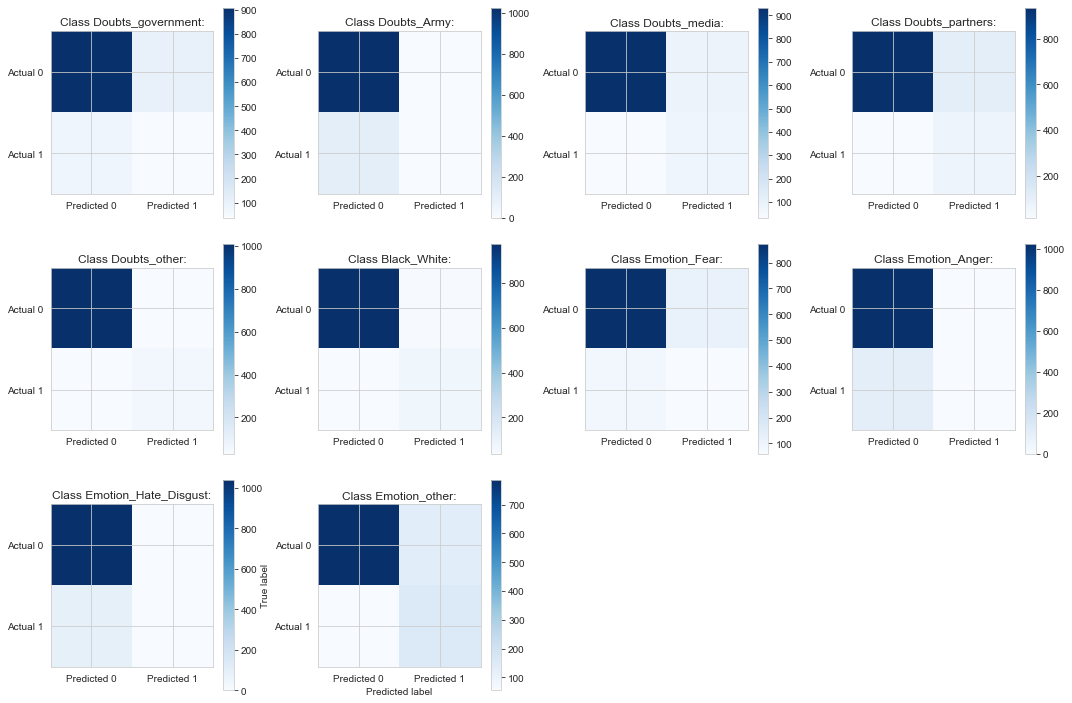

In [25]:
plt.figure(figsize=(15, 10))

# Iterate through the confusion matrices and plot them in a single plot
for i, confusion_matrix in enumerate(mcm):
    tn, fp, fn, tp = confusion_matrix.ravel()
    matrix = np.array([[tn, fp], [fn, tp]])
    plt.subplot(3, 4, i + 1)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Class {class_names[i]}:')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Predicted 0', 'Predicted 1'])
    plt.yticks(tick_marks, ['Actual 0', 'Actual 1'])

# Adjust layout and labels
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


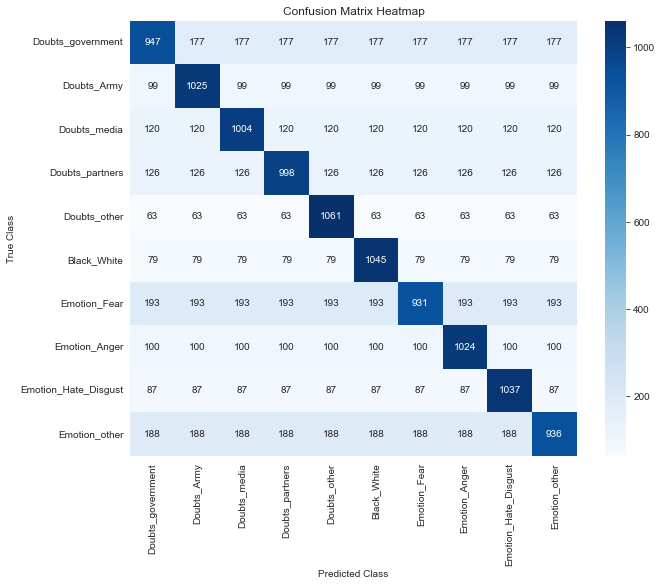

In [26]:
# Compute multilabel confusion matrix with class names
mcm = multilabel_confusion_matrix(true_labels, predicted_labels, labels=class_names)

# Create an empty confusion matrix to accumulate values
confusion_matrix_heatmap = np.zeros((len(class_names), len(class_names)), dtype=int)

# Populate the confusion matrix heatmap with the values from the multilabel confusion matrix
for i, confusion_matrix in enumerate(mcm):
    tn, fp, fn, tp = confusion_matrix.ravel()
    confusion_matrix_heatmap[i, i] = tn + tp  # Diagonal contains true negatives and true positives
    for j in range(len(class_names)):
        if j != i:
            confusion_matrix_heatmap[i, j] = fp + fn  # Off-diagonal contains false positives and false negatives

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix_heatmap, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix Heatmap')
plt.show()


5 epoch

In [57]:
# Initialize lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the keys of the dictionaries
for key in true_dict.keys():
    # Check if the key exists in both dictionaries
    if key in pred_dict:
        # Append true and predicted labels
        true_labels.extend(true_dict[key])
        predicted_labels.extend(pred_dict[key])

# Generate classification report
report = classification_report(true_labels, predicted_labels)

# Print classification report
print(report)

                      precision    recall  f1-score   support

         Black_White       0.86      0.85      0.86       108
         Doubts_Army       0.94      0.88      0.91        99
   Doubts_government       0.42      0.40      0.41       115
        Doubts_media       0.93      0.95      0.94       106
        Doubts_other       0.93      0.95      0.94        83
     Doubts_partners       0.85      0.85      0.85        81
       Emotion_Anger       0.27      0.39      0.32       100
        Emotion_Fear       0.48      0.49      0.48       138
Emotion_Hate_Disgust       0.21      0.06      0.09        87
       Emotion_other       0.57      0.64      0.60       207

            accuracy                           0.64      1124
           macro avg       0.65      0.65      0.64      1124
        weighted avg       0.63      0.64      0.63      1124


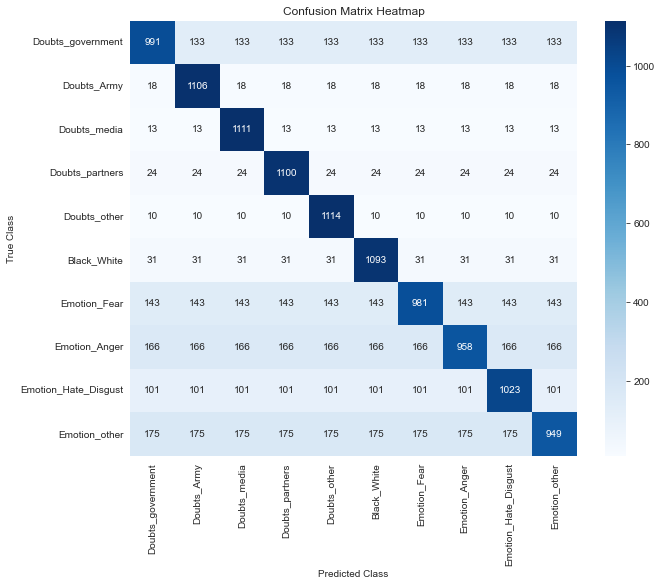

In [58]:
# Compute multilabel confusion matrix with class names
mcm = multilabel_confusion_matrix(true_labels, predicted_labels, labels=class_names)

# Create an empty confusion matrix to accumulate values
confusion_matrix_heatmap = np.zeros((len(class_names), len(class_names)), dtype=int)

# Populate the confusion matrix heatmap with the values from the multilabel confusion matrix
for i, confusion_matrix in enumerate(mcm):
    tn, fp, fn, tp = confusion_matrix.ravel()
    confusion_matrix_heatmap[i, i] = tn + tp  # Diagonal contains true negatives and true positives
    for j in range(len(class_names)):
        if j != i:
            confusion_matrix_heatmap[i, j] = fp + fn  # Off-diagonal contains false positives and false negatives

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix_heatmap, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix Heatmap')
plt.show()

#### 5 epoch no weight

In [4]:
# Initialize lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the keys of the dictionaries
for key in true_dict.keys():
    # Check if the key exists in both dictionaries
    if key in pred_dict:
        # Append true and predicted labels
        true_labels.extend(true_dict[key])
        predicted_labels.extend(pred_dict[key])

# Generate classification report
report = classification_report(true_labels, predicted_labels)

# Print classification report
print(report)

                      precision    recall  f1-score   support

         Black_White       0.86      0.88      0.87       108
         Doubts_Army       0.98      0.86      0.91        99
   Doubts_government       0.39      0.36      0.37       115
        Doubts_media       0.94      0.93      0.94       106
        Doubts_other       0.95      0.93      0.94        83
     Doubts_partners       0.87      0.85      0.86        81
       Emotion_Anger       0.31      0.29      0.30       100
        Emotion_Fear       0.43      0.51      0.47       138
Emotion_Hate_Disgust       0.19      0.03      0.06        87
       Emotion_other       0.55      0.75      0.64       207

            accuracy                           0.64      1124
           macro avg       0.65      0.64      0.64      1124
        weighted avg       0.63      0.64      0.63      1124


In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

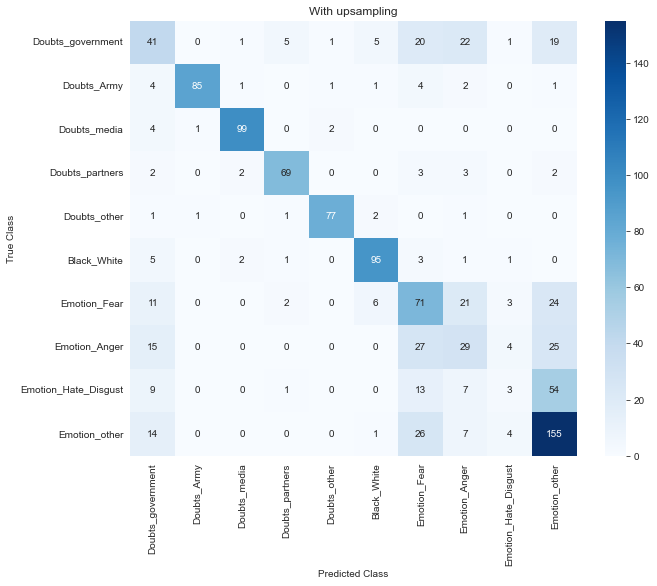

Predictions when true label is 'Emotion_Hate':
Doubts_government        9
Doubts_Army              0
Doubts_media             0
Doubts_partners          1
Doubts_other             0
Black_White              0
Emotion_Fear            13
Emotion_Anger            7
Emotion_Hate_Disgust     3
Emotion_other           54
Name: Emotion_Hate_Disgust, dtype: int64


In [20]:
# Confuse class Emotion_Hate_Disgust
class_names = ["Doubts_government", 
               "Doubts_Army",
               "Doubts_media",
               "Doubts_partners",
               "Doubts_other",
               "Black_White",
               "Emotion_Fear",
               "Emotion_Anger",
               "Emotion_Hate_Disgust",
               "Emotion_other"]

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=class_names)

# Convert confusion matrix to DataFrame for better readability
conf_matrix_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

# Extract the row corresponding to 'Emotion_Hate'
emotion_hate_row = conf_matrix_df.loc['Emotion_Hate_Disgust']

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('With upsampling')
plt.show()

# Display the predictions when true label is 'Emotion_Hate'
print(f"Predictions when true label is 'Emotion_Hate':")
print(emotion_hate_row)

# 5 epoch no weight dev with no upsample

In [39]:
# Initialize lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the keys of the dictionaries
for key in true_dict.keys():
    # Check if the key exists in both dictionaries
    if key in pred_dict:
        # Append true and predicted labels
        true_labels.extend(true_dict[key])
        predicted_labels.extend(pred_dict[key])

# Generate classification report
report = classification_report(true_labels, predicted_labels)

# Print classification report
print(report)

                      precision    recall  f1-score   support

         Black_White       0.63      0.92      0.75        37
         Doubts_Army       1.00      0.10      0.19        29
   Doubts_government       0.57      0.68      0.62       144
        Doubts_media       1.00      0.81      0.90        27
        Doubts_other       0.00      0.00      0.00         2
     Doubts_partners       0.67      0.62      0.64        13
       Emotion_Anger       0.50      0.32      0.39       158
        Emotion_Fear       0.55      0.78      0.65       179
Emotion_Hate_Disgust       0.23      0.03      0.05       105
       Emotion_other       0.74      0.88      0.80       338

            accuracy                           0.63      1032
           macro avg       0.59      0.51      0.50      1032
        weighted avg       0.60      0.63      0.59      1032


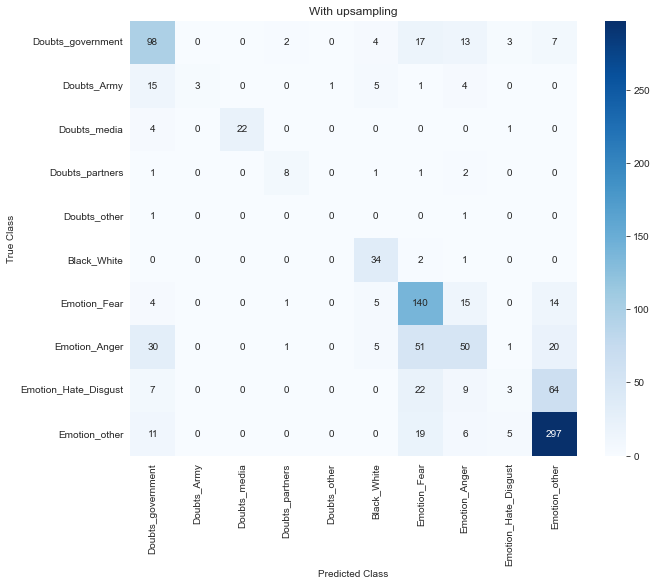

Predictions when true label is 'Emotion_Hate':
Doubts_government        7
Doubts_Army              0
Doubts_media             0
Doubts_partners          0
Doubts_other             0
Black_White              0
Emotion_Fear            22
Emotion_Anger            9
Emotion_Hate_Disgust     3
Emotion_other           64
Name: Emotion_Hate_Disgust, dtype: int64


In [40]:
# Confuse class Emotion_Hate_Disgust
class_names = ["Doubts_government", 
               "Doubts_Army",
               "Doubts_media",
               "Doubts_partners",
               "Doubts_other",
               "Black_White",
               "Emotion_Fear",
               "Emotion_Anger",
               "Emotion_Hate_Disgust",
               "Emotion_other"]

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=class_names)

# Convert confusion matrix to DataFrame for better readability
conf_matrix_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

# Extract the row corresponding to 'Emotion_Hate'
emotion_hate_row = conf_matrix_df.loc['Emotion_Hate_Disgust']

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('With upsampling')
plt.show()

# Display the predictions when true label is 'Emotion_Hate'
print(f"Predictions when true label is 'Emotion_Hate':")
print(emotion_hate_row)

# 5 epoch with weight dev with no upsample

In [20]:
# Initialize lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the keys of the dictionaries
for key in true_dict.keys():
    # Check if the key exists in both dictionaries
    if key in pred_dict:
        # Append true and predicted labels
        true_labels.extend(true_dict[key])
        predicted_labels.extend(pred_dict[key])

# Generate classification report
report = classification_report(true_labels, predicted_labels)

# Print classification report
print(report)

                      precision    recall  f1-score   support

         Black_White       0.46      0.68      0.55        37
         Doubts_Army       0.39      0.38      0.39        29
   Doubts_government       0.14      0.03      0.06       144
        Doubts_media       0.59      0.85      0.70        27
        Doubts_other       0.50      1.00      0.67         2
     Doubts_partners       0.22      1.00      0.37        13
       Emotion_Anger       0.00      0.00      0.00       158
        Emotion_Fear       0.28      0.60      0.38       179
Emotion_Hate_Disgust       0.00      0.00      0.00       105
       Emotion_other       0.63      0.79      0.70       338

            accuracy                           0.44      1032
           macro avg       0.32      0.53      0.38      1032
        weighted avg       0.32      0.44      0.36      1032


C:\Users\Ната\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ната\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ната\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo